In [6]:
bsc = xr.open_dataset("nc_files/EMA-RegCM4/20211201_EMA-RegCM4.nc")
bsc


<xarray.Dataset>
Dimensions:     (lon: 421, lat: 196, time: 25)
Coordinates:
  * lon         (lon) float64 -66.5 -66.1 -65.7 -65.3 ... 100.7 101.1 101.5
  * lat         (lat) float64 -9.61 -9.21 -8.81 -8.41 ... 67.59 67.99 68.39
  * time        (time) datetime64[ns] 2021-12-01 ... 2021-12-04
Data variables:
    OD550_DUST  (time, lat, lon) float32 ...
    SCONC_DUST  (time, lat, lon) float32 ...

In [7]:
#11 19
bsc.time.to_series()[19]

Timestamp('2021-12-03 09:00:00')

In [8]:
nc_files = os.listdir("nc_files/EMA-RegCM4/")
len(nc_files)

56

In [9]:
day1_lead_all = pd.DataFrame(columns=["stn", "lon", "lat"])
for nc_file in nc_files:
    bsc = xr.open_dataset("nc_files/EMA-RegCM4/"+nc_file)
    day1_lead = [["stn", "lon", "lat", bsc.OD550_DUST.time.to_series()[19]]]
    for i in range(len(stn)):
        day1_bsc = bsc.OD550_DUST.isel(time = 19).sel(lat = stn_lat[i], 
                                                     lon = stn_lon[i], 
                                                     method = 'nearest')
        day1_lead.append([stn[i], stn_lon[i], stn_lat[i], day1_bsc.to_dict()["data"]])
    day1_lead = pd.DataFrame(day1_lead[1:len(day1_lead)], columns = day1_lead[0])
    day1_lead_all = day1_lead_all.merge(day1_lead, 
                                        left_on=["stn", "lon", "lat"], 
                                        right_on=["stn", "lon", "lat"],
                                        how = "outer")
#data for 1 day leadtime for all sations
day1_lead_all

,stn,lon,lat,2021-12-03 09:00:00,2021-12-04 09:00:00,2021-12-05 09:00:00,2021-12-07 09:00:00,2021-12-08 09:00:00,2021-12-09 09:00:00,2021-12-10 09:00:00,...,2022-01-24 09:00:00,2022-01-25 09:00:00,2022-01-26 09:00:00,2022-01-27 09:00:00,2022-01-28 09:00:00,2022-01-29 09:00:00,2022-01-30 09:00:00,2022-01-31 09:00:00,2022-02-01 09:00:00,2022-02-02 09:00:00
0,ABE,3.33,7.20,0.080899,0.001226,0.000628,0.000695,0.000420,0.013826,0.089099,...,0.003795,0.010233,0.069612,0.010812,0.239211,1.097202,0.394835,0.417045,0.320976,0.302754
1,ABK,8.19,6.25,0.242509,0.033479,0.006687,0.008684,0.015080,0.204455,0.975564,...,0.022020,0.031353,0.280405,0.327033,1.208115,0.846426,0.336574,0.307712,0.271139,0.273714
2,ABU,7.20,9.00,1.173148,0.202179,0.072461,0.340343,0.042023,0.589959,0.930294,...,0.033084,0.045432,0.132042,0.529490,1.868398,1.070704,0.295426,0.382073,0.686021,0.359153
3,ADO,5.20,7.60,0.410603,0.028026,0.002486,0.012701,0.001645,0.180585,0.391732,...,0.013829,0.010116,0.071767,0.109267,0.946668,1.148471,0.464688,0.471751,0.454218,0.327822
4,AKU,5.30,7.20,0.354113,0.025879,0.002716,0.027735,0.001655,0.108476,0.463418,...,0.004695,0.003808,0.058224,0.095004,1.076687,1.070871,0.492259,0.464413,0.358669,0.179061
5,ASA,6.23,6.82,0.293395,0.024790,0.002477,0.023681,0.002327,0.102389,0.817221,...,0.002721,0.003840,0.080690,0.126506,1.067409,0.770465,0.394608,0.395078,0.318111,0.020290
6,AWK,7.07,6.20,0.189455,0.016992,0.003711,0.005741,0.005792,0.092165,0.829890,...,0.006134,0.010457,0.132623,0.162165,1.011004,0.814305,0.288094,0.292565,0.295844,0.059496
7,BAU,9.82,10.28,0.891650,0.361988,0.126913,0.253849,0.306225,1.720319,0.628287,...,0.098052,0.221448,0.385988,1.276245,2.532645,1.179467,0.419642,0.455976,1.381404,0.744592
8,BEN,5.60,6.33,0.169453,0.006696,0.001307,0.014326,0.001360,0.051358,0.249400,...,0.000868,0.000691,0.011623,0.034821,0.637740,1.038165,0.576361,0.461021,0.190849,0.008305
9,BID,6.00,9.80,1.033867,0.374210,0.061062,0.356181,0.066582,0.509407,0.665779,...,0.059493,0.061753,0.172277,0.469722,1.833268,0.816829,0.240355,0.748524,1.060103,0.588961


In [10]:
day1_lead_all_t = day1_lead_all.transpose()
day1_lead_all_t.columns = day1_lead_all_t.iloc[0]
day1_lead_all_t = day1_lead_all_t.drop(["lon", "lat", "stn"])

# multiply AOD by 10
# day1_lead_all_t = day1_lead_all_t * 10

day1_lead_all_t = day1_lead_all_t.reset_index()
day1_lead_all_t

stn,index,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
0,2021-12-03 09:00:00,0.080899,0.242509,1.173148,0.410603,0.354113,0.293395,0.189455,0.89165,0.169453,...,1.671696,0.109824,0.29007,0.146526,0.190933,0.096969,1.060185,0.125229,1.060833,0.772364
1,2021-12-04 09:00:00,0.001226,0.033479,0.202179,0.028026,0.025879,0.02479,0.016992,0.361988,0.006696,...,0.269844,0.00573,0.399413,0.023162,0.02998,0.004037,0.488178,0.005311,0.226518,0.328785
2,2021-12-05 09:00:00,0.000628,0.006687,0.072461,0.002486,0.002716,0.002477,0.003711,0.126913,0.001307,...,0.130711,0.001456,0.11506,0.002597,0.003142,0.000379,0.047567,0.000121,0.051058,0.144225
3,2021-12-07 09:00:00,0.000695,0.008684,0.340343,0.012701,0.027735,0.023681,0.005741,0.253849,0.014326,...,0.299563,0.003254,0.206168,0.001844,0.003365,0.004986,0.255241,0.000732,0.39842,0.16692
4,2021-12-08 09:00:00,0.00042,0.01508,0.042023,0.001645,0.001655,0.002327,0.005792,0.306225,0.00136,...,0.595932,0.000796,0.570042,0.007129,0.008146,0.001366,0.297461,0.001996,0.091116,0.529096
5,2021-12-09 09:00:00,0.013826,0.204455,0.589959,0.180585,0.108476,0.102389,0.092165,1.720319,0.051358,...,2.209675,0.293855,0.596124,0.046413,0.036447,0.035554,0.493299,0.010699,1.145105,0.98295
6,2021-12-10 09:00:00,0.089099,0.975564,0.930294,0.391732,0.463418,0.817221,0.82989,0.628287,0.2494,...,0.824978,0.467425,0.606532,0.530963,0.484815,0.188649,0.595848,0.110646,0.388547,0.506735
7,2021-12-12 09:00:00,0.004722,0.048098,0.105237,0.024771,0.021505,0.025323,0.02583,0.086828,0.011785,...,0.139592,0.00579,0.157088,0.010076,0.01008,0.005603,0.127985,0.002021,0.093536,0.05968
8,2021-12-13 09:00:00,0.001241,0.068852,0.106979,0.038149,0.019708,0.017714,0.025389,0.097629,0.005097,...,0.194447,0.028837,0.134239,0.011552,0.008133,0.005872,0.098924,0.003995,0.120209,0.069635
9,2021-12-14 09:00:00,0.000365,0.010193,0.072069,0.001974,0.002814,0.007376,0.007241,0.062324,0.004711,...,0.061324,0.014601,0.033825,0.005328,0.005306,0.002721,0.038883,0.003042,0.097353,0.041987


In [11]:
day1_lead_all_t["index"] = pd.to_datetime(day1_lead_all_t["index"], format="%Y-%m-%d").dt.date
day1_lead_all_t = day1_lead_all_t.set_index("index")
day1_lead_all_t

stn,ABE,ABK,ABU,ADO,AKU,ASA,AWK,BAU,BEN,BID,...,POT,SHA,SOK,UMU,UYO,WAR,YEL,YEN,YOL,ZAR
index,,,,,,,,,,,,,,,,,,,,,
2021-12-03,0.080899,0.242509,1.173148,0.410603,0.354113,0.293395,0.189455,0.89165,0.169453,1.033867,...,1.671696,0.109824,0.29007,0.146526,0.190933,0.096969,1.060185,0.125229,1.060833,0.772364
2021-12-04,0.001226,0.033479,0.202179,0.028026,0.025879,0.02479,0.016992,0.361988,0.006696,0.37421,...,0.269844,0.00573,0.399413,0.023162,0.02998,0.004037,0.488178,0.005311,0.226518,0.328785
2021-12-05,0.000628,0.006687,0.072461,0.002486,0.002716,0.002477,0.003711,0.126913,0.001307,0.061062,...,0.130711,0.001456,0.11506,0.002597,0.003142,0.000379,0.047567,0.000121,0.051058,0.144225
2021-12-07,0.000695,0.008684,0.340343,0.012701,0.027735,0.023681,0.005741,0.253849,0.014326,0.356181,...,0.299563,0.003254,0.206168,0.001844,0.003365,0.004986,0.255241,0.000732,0.39842,0.16692
2021-12-08,0.00042,0.01508,0.042023,0.001645,0.001655,0.002327,0.005792,0.306225,0.00136,0.066582,...,0.595932,0.000796,0.570042,0.007129,0.008146,0.001366,0.297461,0.001996,0.091116,0.529096
2021-12-09,0.013826,0.204455,0.589959,0.180585,0.108476,0.102389,0.092165,1.720319,0.051358,0.509407,...,2.209675,0.293855,0.596124,0.046413,0.036447,0.035554,0.493299,0.010699,1.145105,0.98295
2021-12-10,0.089099,0.975564,0.930294,0.391732,0.463418,0.817221,0.82989,0.628287,0.2494,0.665779,...,0.824978,0.467425,0.606532,0.530963,0.484815,0.188649,0.595848,0.110646,0.388547,0.506735
2021-12-12,0.004722,0.048098,0.105237,0.024771,0.021505,0.025323,0.02583,0.086828,0.011785,0.148876,...,0.139592,0.00579,0.157088,0.010076,0.01008,0.005603,0.127985,0.002021,0.093536,0.05968
2021-12-13,0.001241,0.068852,0.106979,0.038149,0.019708,0.017714,0.025389,0.097629,0.005097,0.100248,...,0.194447,0.028837,0.134239,0.011552,0.008133,0.005872,0.098924,0.003995,0.120209,0.069635


In [12]:
# na.array(vis['YOL'])
# merged = pd.merge(vis[["YOL"]], day1_lead_all_t[["YOL"]], left_index=True, right_on="index")
merged = pd.concat([vis[["YOL"]], day1_lead_all_t[["YOL"]]], axis=1)
merged.columns = ["Visibility", "AOD"]
merged

,Visibility,AOD
2021-12-01,10.0,NaN
2021-12-02,1.0,NaN
2021-12-03,1.6,1.060833
2021-12-04,2.0,0.226518
2021-12-05,5.0,0.051058
...,...,...
2022-01-29,5.0,0.850202
2022-01-30,5.0,0.424328
2022-01-31,8.0,0.552558
2022-02-01,NaN,1.616346


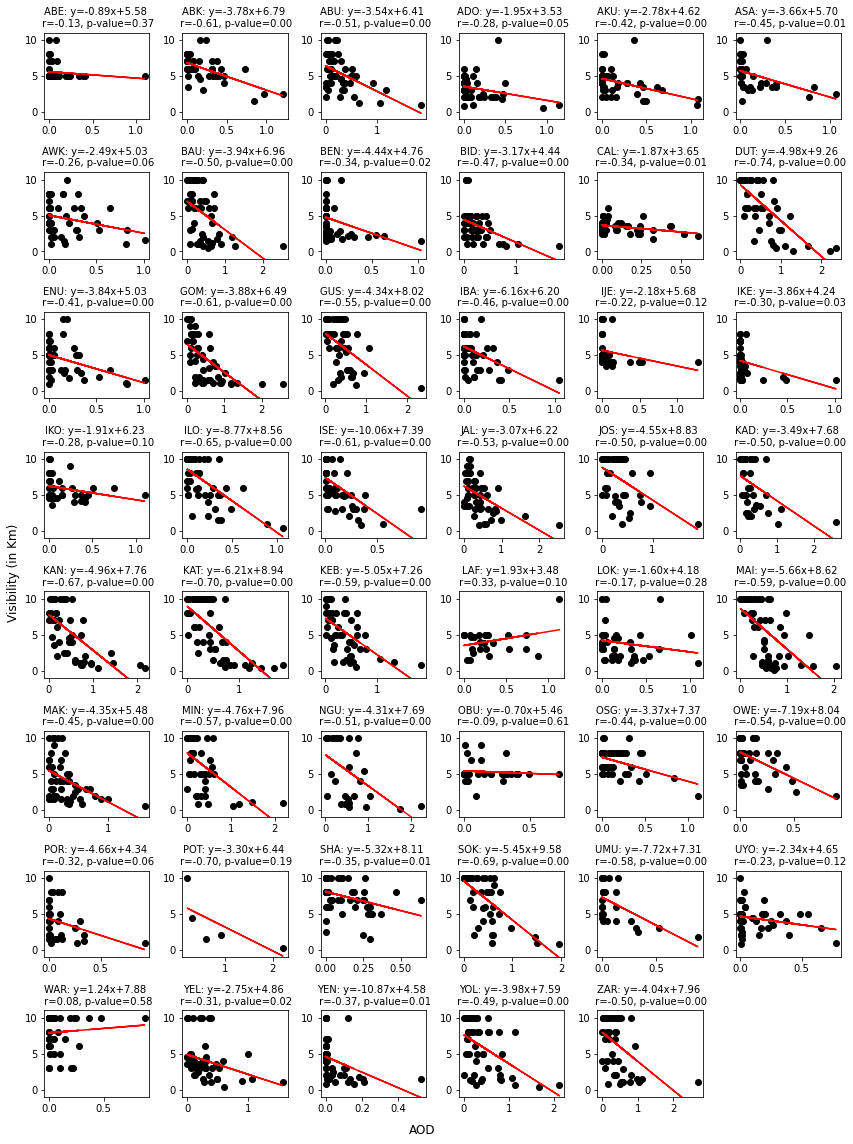

In [13]:
# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

cor_ls = []

fig = plt.figure(figsize=(12,16))
# fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, j in enumerate(stn):
    merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
    merged.columns = ["Visibility", "AOD"]
    a=merged.dropna()
#     regression part
    slope, intercept, r_value, p_value, std_err = stats.linregress(list(a['AOD']),list(a['Visibility']))
    line = (slope*a['AOD'])+intercept
    
    # append correlation
    cor_ls.append([stn_lat[i], stn_lon[i], j, round(r_value, 2), round(p_value, 2)])
    
    ax = fig.add_subplot(8,6,i+1, )
    ax.scatter(merged['AOD'], merged['Visibility'], color = 'k')
    ax.plot(list(a['AOD']), line, 'r')
    title = j+': y={:.2f}x+{:.2f} \n '.format(slope,intercept)  + 'r={:.2f}, '.format(r_value) + 'p-value={:.2f}'.format(p_value)

    ax.set_title(title, fontsize = 10)
#     ax.set_xlim([0, 1.5])
    ax.set_ylim([-1, 11])
    
#     ax.set_ylabel('Visibility (in Km)')
#     ax.set_xlabel('bbb')
# fig.suptitle('a')
fig.supxlabel('AOD')
fig.supylabel('Visibility (in Km)')
fig.tight_layout(rect=(0.0,0,1,1))
    
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("common X")
# plt.ylabel("common Y")    
#     plt.subplot(7,7,i+1)
#     plt.scatter(merged['AOD'], merged['Visibility'], color = 'k', ls='solid')
#     plt.title(j)
# plt.xlabel('AOD')
# plt.ylabel('Visibility (in Km)')
#     plt.text(j)
#     for j in stn:
        
#         plt.subplot(2, 3, i)
#         plt.scatter(merged['AOD'], merged['Visibility'])
# # #         plt.text(0.5, 0.5, str((2, 3, i)),
# # #                  fontsize=18, ha='center')
            


# # fig = plt.figure(figsize=(3,3))
# fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(15,15))
# plt.subplots_adjust(hspace=0.2)
# for j, ax in zip(stn, axs.ravel()):
#     print(j, ax)
#     merged = pd.concat([vis[[j]], day1_lead_all_t[[j]]], axis=1)
#     merged.columns = ["Visibility", "AOD"]
# #     merged['AOD'].scatter(merged['Visibility'],ax=ax)
#     plt.scatter(merged['AOD'], merged['Visibility'],ax=ax)
# #     plt.figure()
# #     plt.scatter(merged['AOD'], merged['Visibility'],color='k', ls='solid')
# #     plt.show()
    
    

In [14]:
cor_df = pd.DataFrame(cor_ls, columns=["Lat", "Long", "Station", "r_value", "p_value"])
cor_df['p'] = 2
cor_df.loc[cor_df['p_value'] > 0.05, 'p'] = 1
cor_df

,Lat,Long,Station,r_value,p_value,p
0,7.20,3.33,ABE,-0.13,0.37,1
1,6.25,8.19,ABK,-0.61,0.00,2
2,9.00,7.20,ABU,-0.51,0.00,2
3,7.60,5.20,ADO,-0.28,0.05,2
4,7.20,5.30,AKU,-0.42,0.00,2
5,6.82,6.23,ASA,-0.45,0.01,2
6,6.20,7.07,AWK,-0.26,0.06,1
7,10.28,9.82,BAU,-0.50,0.00,2
8,6.33,5.60,BEN,-0.34,0.02,2
9,9.80,6.00,BID,-0.47,0.00,2


In [15]:
# cor_df.to_csv("cor_files/day1/EMA-RegCM4_1d.csv", index=False)
cor_df.to_csv("cor_files/day2/EMA-RegCM4_2d.csv", index=False)
# cor_df.to_csv("cor_files/day3/EMA-RegCM4_3d.csv", index=False)

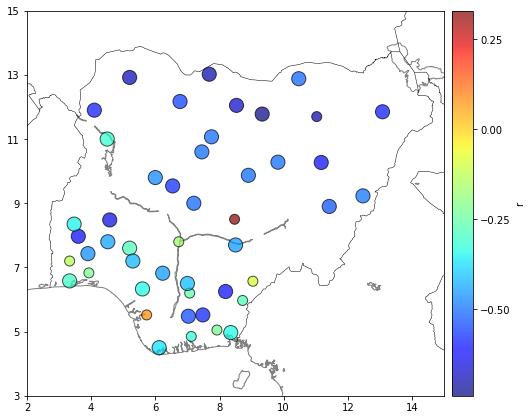

In [16]:
# plot coastlines with Basemap
plt.figure(figsize=(8, 8))
m = Basemap(projection='cyl', resolution='h',
llcrnrlat=3, urcrnrlat=15,
llcrnrlon=2, urcrnrlon=15)
# m.drawmapboundary(fill_color='#DDEEFF')
# m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='grey', zorder=2)
m.drawcountries(color='black', zorder=2)
# m.shadedrelief()
m.drawstates()

# m.readshapefile('./nigeria_states/nigeria_states', 'nigeria_states')

# plot locations
m.scatter(cor_df["Long"], cor_df["Lat"], latlon=True, 
          c=cor_df["r_value"], s=cor_df["p"]*100,
          edgecolors="black", zorder=3,
          cmap='jet', alpha=0.7)

# create colorbar and legend
m.colorbar(label=r'r', ticks=np.linspace(1, -1, 9), shrink=0.755)
# plt.set_ticks(np.linspace(1, -1, 9))
plt.xticks(range(2, 16, 2))
plt.yticks(range(3, 16, 2))
plt.show()